# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

rcParams['font.size'] = 18

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def bin_same_night(rv):
    rv['jd_date'] = rv['time'].apply(lambda x: int(np.floor(x)))
    rv_mean = rv.groupby('jd_date',as_index=False).agg(
        {'time': 'mean', 'mnvel': 'mean', 'errvel': 'mean', 'tel': 'first'}
    )
    rv_n = rv.groupby('jd_date',as_index=False).size()["size"]
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = linspace(t_start,t_stop,10000)

In [3]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params['tc1'] = radvel.Parameter(value=2456778 + 1)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1)
    params['per2'] = radvel.Parameter(value=75.765 + 0.1)
    params['tc2'] = radvel.Parameter(value=2456277.6)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1)
    params['dvdt'] = radvel.Parameter(value=0)
    params['curv'] = radvel.Parameter(value=0)
    mod = radvel.RVModel(params, time_base=time_base)
    return mod


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

Setting vary=False and linear=True on the gamma parameters will cause them to be solved for analytically following the technique described [here](http://cadence.caltech.edu/~bfulton/share/Marginalizing_the_likelihood.pdf) (Thanks Tim Brandt!). If you use this you will need to calculate the uncertainties on the gammas manually following that derivation.

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_hires_rj.params['jit_hires_rj'] = radvel.Parameter(value=np.log(1))

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_hires_rk.params['jit_hires_rk'] = radvel.Parameter(value=np.log(1))

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = radvel.Parameter(value=1.0, vary=False, linear=True)
like_apf.params['jit_apf'] = radvel.Parameter(value=np.log(1))

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = radvel.Parameter(value=log(2.6))
like.params['jit_hires_rj'] = radvel.Parameter(value=log(2.6))
like.params['jit_apf'] = radvel.Parameter(value=log(2.6))

# Do not vary dvdt or jitter (Fulton 2015)
like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['jit_hires_rk'].vary = False
like.params['jit_hires_rj'].vary = False
like.params['jit_apf'].vary = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1309.928781
Final loglikelihood = -767.134507
parameter                     value      vary
per1                        1198.64       True
tc1                        -2.44253       True
secosw1                   -0.223476       True
sesinw1                    0.254041       True
logk1                       1.97241       True
per2                        75.7709       True
tc2                        -499.729       True
secosw2                  -0.0327122       True
sesinw2                    0.436144       True
logk2                      0.767926       True
dvdt                              0      False
curv                              0      False
gamma_hires_rj             0.227884      False
jit_hires_rj               0.955511      False
gamma_hires_rk             0.166191      False
jit_hires_rk               0.955511      False
gamma_apf                  0.998124      False
jit_apf                    0.955511      False
tp1                          108.13  

# Perform MCMC posterior exploration

In [6]:
df = radvel.mcmc(post, nrun=200, savename='rawchains.h5')

20000/80000 (25.0%) steps complete; Running 8033.22 steps/s; Mean acceptance rate = 46.9%; Min Auto Factor =  21; Max Auto Relative-Change =   inf; Min Tz = 3234.2; Max G-R = 1.009
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 8084.80 steps/s; Mean acceptance rate = 40.8%; Min Auto Factor =  24; Max Auto Relative-Change = 0.535; Min Tz = 5123.2; Max G-R = 1.005

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [7]:
df_synth = post.params.basis.to_synth(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 '.split()
df_synth[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.50,0.84
per1,1.197253e+03,1.198630e+03,1.199629e+03
tc1,2.456772e+06,2.456776e+06,2.456779e+06
e1,9.282648e-02,1.144320e-01,1.361123e-01
k1,7.001871e+00,7.185463e+00,7.356787e+00
per2,7.574226e+01,7.577132e+01,7.579673e+01
tc2,2.456277e+06,2.456278e+06,2.456279e+06
e2,1.131573e-01,1.907526e-01,2.516155e-01
k2,1.957163e+00,2.134227e+00,2.294827e+00


Compare with parameters from fulton et al. (2016)
---------

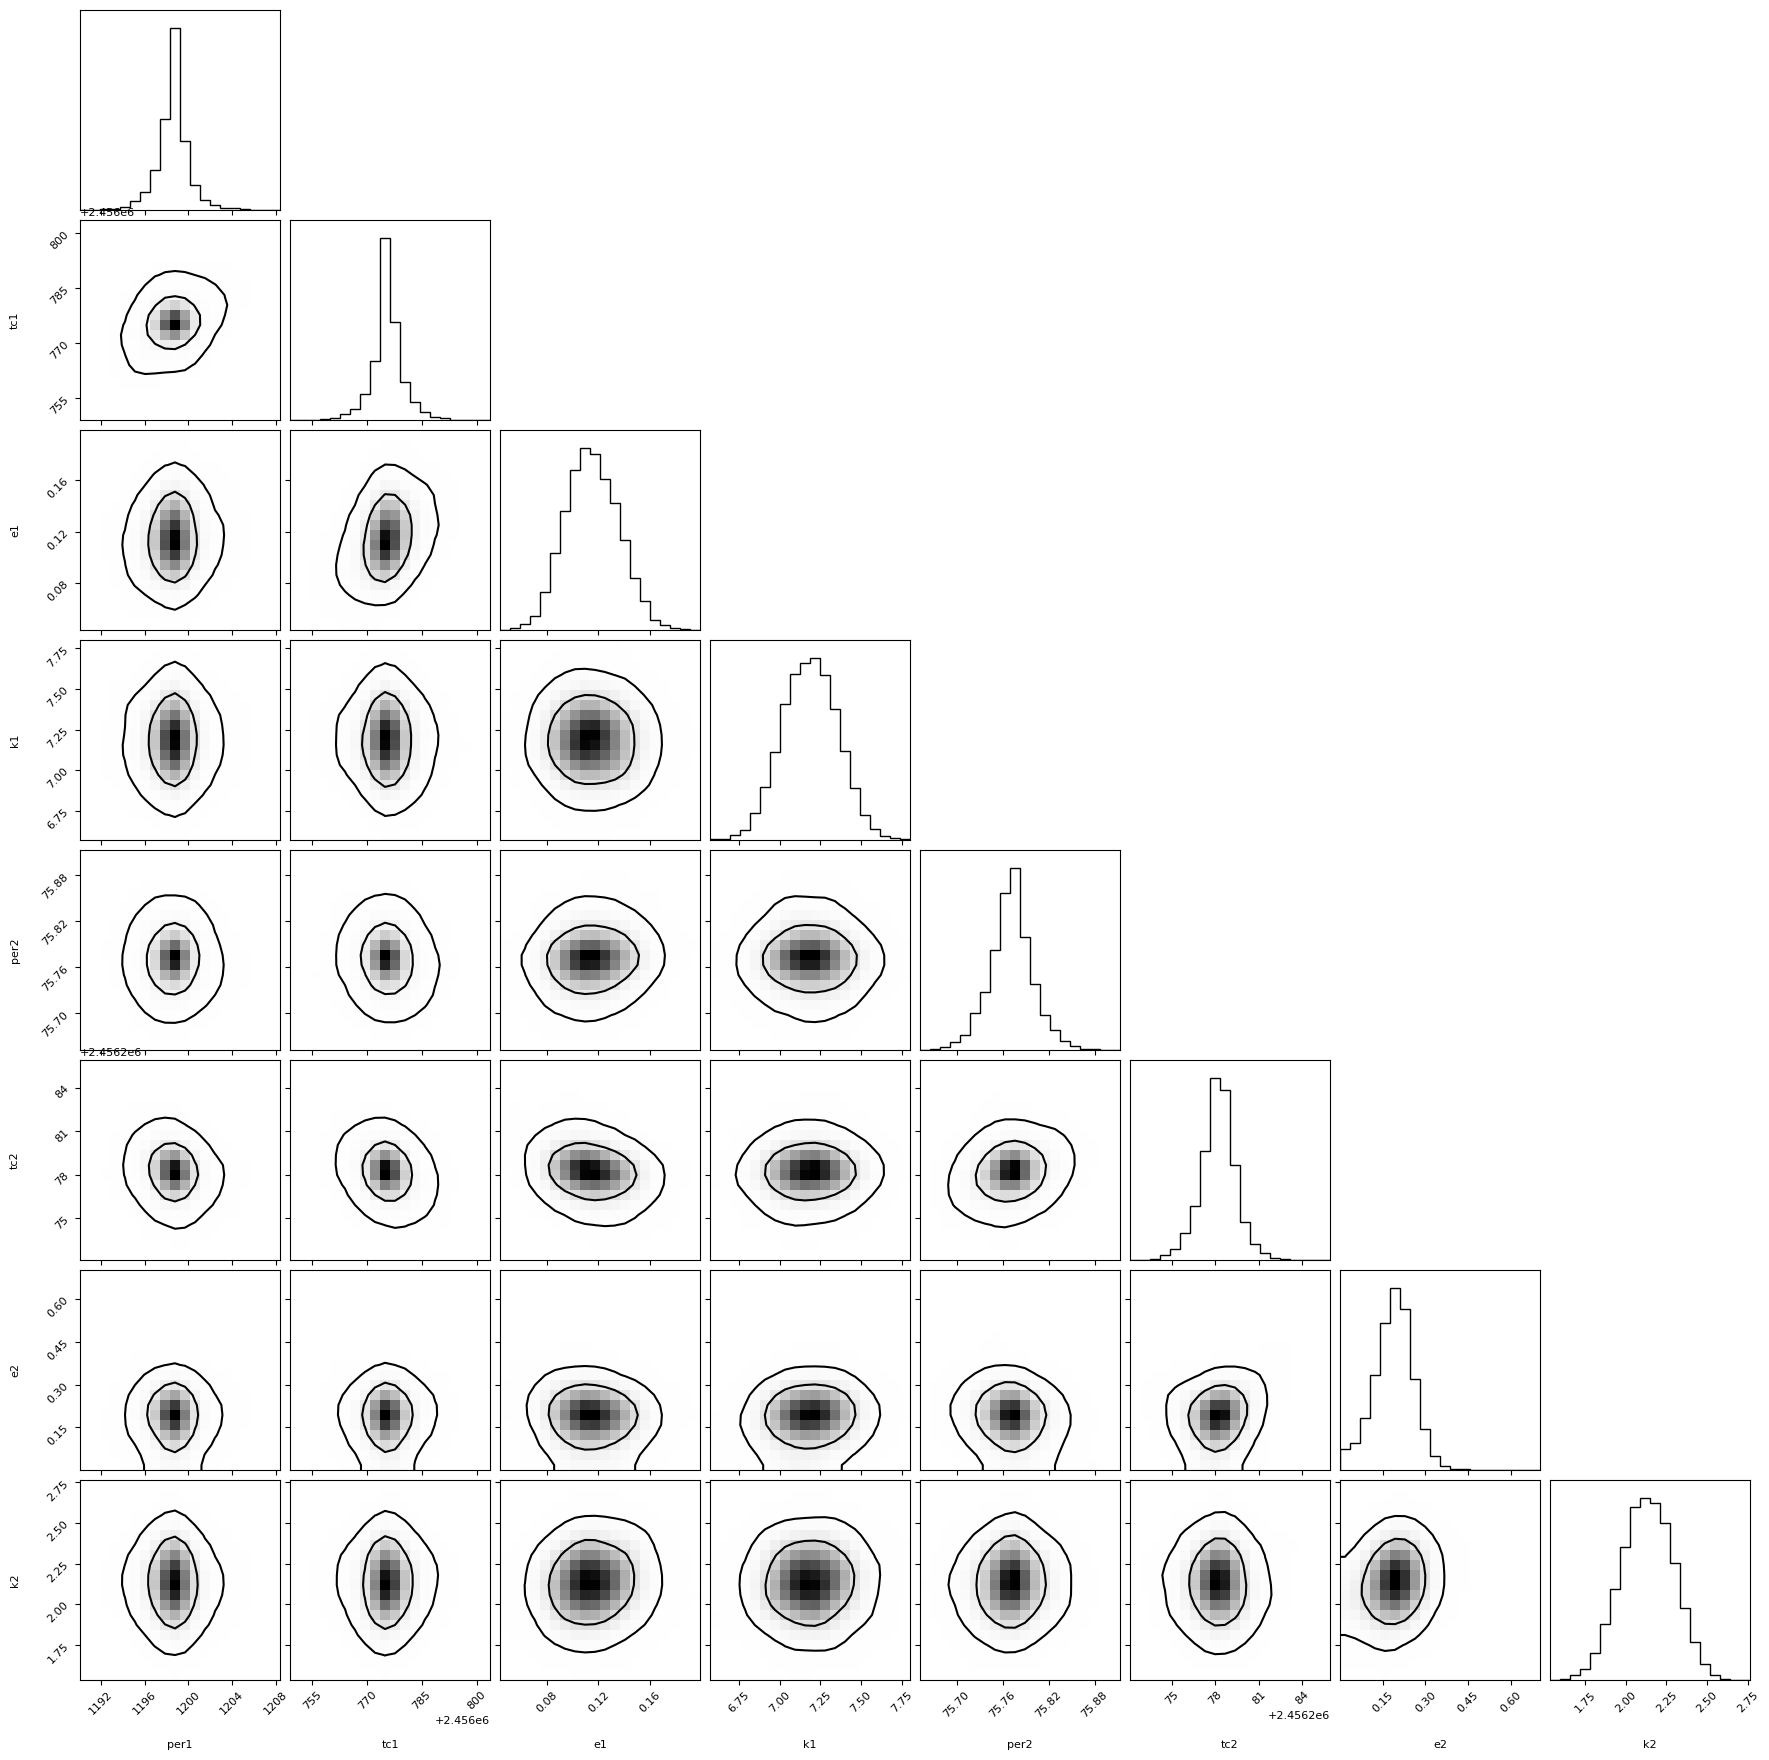

In [8]:
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2'.split()
rc('font',size=8)

fig = corner.corner(
    df_synth[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

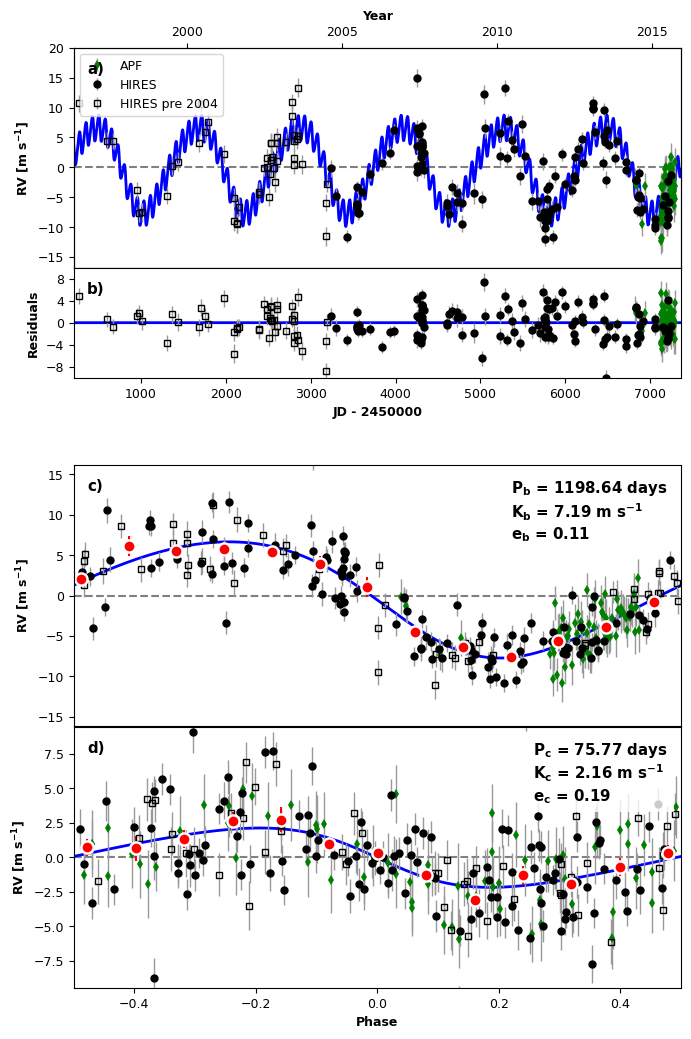

In [9]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()
plt.show()